In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.utils import *
from aeons.endpoint import EndModel, theta_basic, theta_bandwidth, theta_bandwidth_trunc
from aeons.plotting import *
from aeons.regress import *

In [2]:
class Regress:
    def __init__(self, logL, X):
        self.logL = np.array(logL)
        self.X = np.array(X)
        self.N = len(logL)
        
    def theta(self, minimiser, x0):
        return minimiser(self.logL, self.X, x0)
    
    def L_sq(self, theta):
        loss = self.logL - full.func(self.X, theta)
        return np.sum(loss**2)
    
    def s(self, theta):
        return np.sqrt(self.L_sq(theta)/self.N)
    
    def logPr(self, theta):
        L_sq = self.L_sq(theta)
        s = np.sqrt(L_sq/self.N)
        return -1/2 * self.N * np.log(2*np.pi*s**2) - L_sq/(2*s**2)
    
    def logZ(self, theta_max=None, details=False):
        logPr_max = self.logPr(theta_max)
        H = self.hess(theta_max)
        D = len(theta_max) + 1
        return logZ_formula(logPr_max, H, D, details)
    
    def hess(self, theta_max=None):
        import torch
        from torch.autograd.functional import hessian
        s = self.s(theta_max)
        logL = torch.from_numpy(self.logL)
        mean = torch.from_numpy(self.X)
        theta_s_max = torch.tensor([*theta_max, s], requires_grad=True)
        def func(theta_s):
            *theta, s = theta_s
            loss = logL - full.func(mean, theta, torched=True)
            L_sq = torch.sum(loss**2)
            return -1/2 * self.N * torch.log(2*torch.pi*s**2) - L_sq/(2*s**2)
        H = hessian(func, theta_s_max)
        return np.array(H)
    
    def covtheta(self, theta_max=None):
        """Redefine to exclude rows/columns with covariance of s"""
        Dtheta = len(theta_max)
        H = self.hess(theta_max)
        return np.linalg.inv(-H[:Dtheta, :Dtheta])

### Build Cauchy regression and GP example
Requires picking initial conditions by eye

In [3]:
def logcauchy(X, theta, torched=False):
    logLmax, c, gamma = theta
    if torched:
        import torch
        return logLmax - (1 + c)/2 * torch.log( 1 + X**(2/c)/(gamma**2) )
    return logLmax - (1 + c)/2 * np.log( 1 + (X/gamma)**(2/c) )

def minimise_cauchy(logL, X, x0):
    Xd = X/X[0]
    def func(theta):
        return np.sum((logL - logcauchy(Xd, theta))**2)
    from scipy.optimize import minimize
    theta = minimize(func, x0, bounds=((None, None), (0, np.inf), (0, np.inf))).x
    theta[2] *= X[0]
    return theta

In [4]:
# samples = pickle_in(f"{aeons_dir}/samples/toy/planck.pickle")
# samples = pickle_in(f"{aeons_dir}/samples/toy/cauchy_10_0001.pickle")
samples = pickle_in(f"{aeons_dir}/samples/gp.pickle")
model = EndModel(samples)
logLlive, Xlive, nk, logZdead = model.data(ndead=30000, live=True)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))
/tmp/ipykernel_694440/3457646657.py:6: RuntimeWarning: divide by zero encountered in divide
  return logLmax - (1 + c)/2 * np.log( 1 + (X/gamma)**(2/c) )
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_694440/3457646657.py:6: RuntimeWarning: overflow encountered in power
  return logLmax - (1 + c)/2 * np.log( 1 + (X/gamma)**(2/c) )
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[8.41543877e+03 2.57519011e-01 1.47958635e-20]')

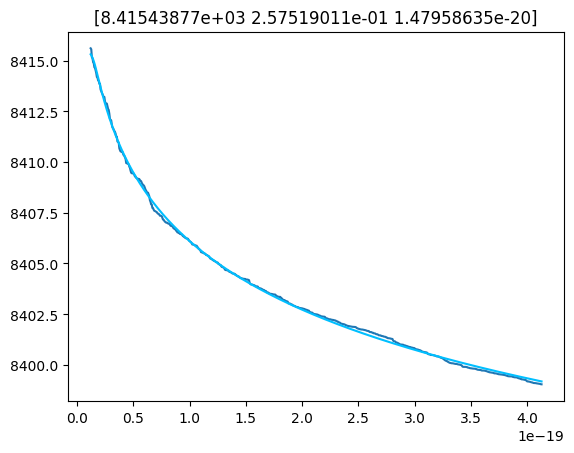

In [5]:
logLlive, Xlive, nk, logZdead = model.data(ndead=30000, live=True)
trunc = 20
logLlive, Xlive = logLlive[:-trunc], Xlive[:-trunc]
theta = minimise_cauchy(logLlive, Xlive, x0=[8415, 0.2, 1e-2])
plt.plot(Xlive, logLlive)
plt.plot(Xlive, logcauchy(Xlive, theta), color='deepskyblue')
plt.title(theta)

In [13]:
logLlive, Xlive, nk, logZdead = model.data(ndead=30000, live=True)
trunc = 20
logLlive, Xlive = logLlive[:-trunc], Xlive[:-trunc]

reg = Regress(logLlive, Xlive)
theta_c = reg.theta(minimise_cauchy, x0=[8415, 0.2, 1e-2])
reg.logZ(theta_c)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))
/tmp/ipykernel_694440/3457646657.py:6: RuntimeWarning: divide by zero encountered in divide
  return logLmax - (1 + c)/2 * np.log( 1 + (X/gamma)**(2/c) )
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_694440/3457646657.py:6: RuntimeWarning: overflow encountered in power
  return logLmax - (1 + c)/2 * np.log( 1 + (X/gamma)**(2/c) )


-2670.6244266135286

In [83]:
ndead = 90000
logLlive, Xlive, nk, logZdead = model.data(ndead, live=True)
trunc = 200
logLlive, Xlive = logLlive[:-trunc], Xlive[:-trunc]
reg = Regress(logLlive, Xlive)
theta_g = reg.theta(analytic_lm_params, x0=2)
reg.logZ(theta_g), theta_g

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


(2191.299963605188,
 [8677.962595800262, 12.053495748026124, 1.2238433070981034e-05])

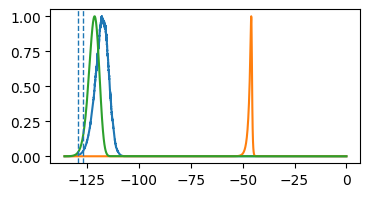

In [84]:
logX, logL = samples.logX(), samples.logL
X, L = np.exp(logX), np.exp(logL - logL.max())
LX = L*X

logLc = logcauchy(X, theta_c)
Lc = np.exp(logLc - logLc.max())
LXc = Lc * X

logLg = full.func(X, theta_g)
Lg = np.exp(logLg - logLg.max())
LXg = Lg * X

plt.figure(figsize=(4,2))
plt.plot(logX, LX/LX.max())
plt.plot(logX, LXc/LXc.max())
plt.plot(logX, LXg/LXg.max())
logXf = logXf_formula(theta_g, logZdead, np.exp(samples.logX().iloc[ndead]))
plt.axvline(x=logXf, lw=1, ls='--')
plt.axvline(x=samples.logX().iloc[ndead], lw=1, ls='--')

<Axes: >

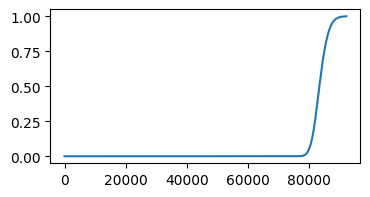

In [49]:
logZs = model.logZs
plt.figure(figsize=(4,2))
np.exp(logZs - logZs.iloc[-1]).plot()

### GP

In [85]:
samples = pickle_in(f"{aeons_dir}/samples/gp.pickle")
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


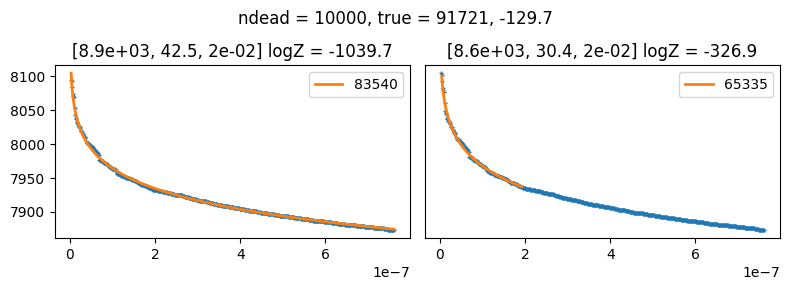

In [90]:
ndead = 10000
plot_split(model, ndead, splits=4, trunc=1)

In [19]:
samples = pickle_in(f"{aeons_dir}/samples/gp.pickle")
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

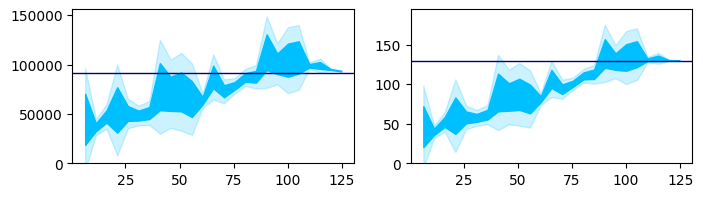

In [95]:
iterations, logXfs, logXfs_std = read_from_txt("gp/bt_full_25.txt")
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = calc_endpoints(iterations, logXs, logXfs, logXfs_std, nlive=1000)
plot_std(-logXs, endpoints, endpoints_std, true_endpoint, ylim=1.7, ax=axs[0])
plot_std(-logXs, -logXfs, logXfs_std, -true_logXf, ylim=(0, -true_logXf*1.5), ax=axs[1])

### Cauchy

In [95]:
samples = pickle_in(f"{aeons_dir}/samples/toy/cauchy_10_0001.pickle")
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

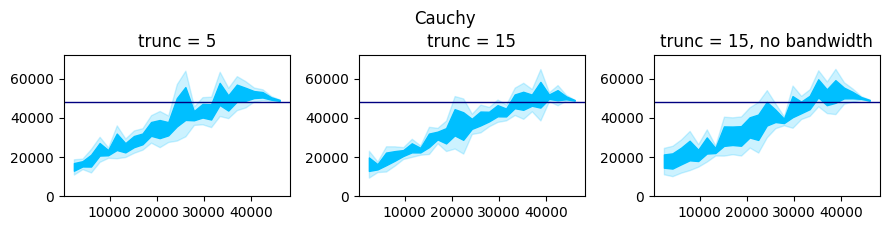

In [146]:
fig, axs = plt.subplots(1, 3, figsize=(9,2.5))
iterations, logXfs, logXfs_std = read_from_txt("cauchy_bt_25_trunc5.txt")
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = calc_endpoints(iterations, logXs, logXfs, logXfs_std, nlive=750)
plot_std(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5, ax=axs[0])

iterations, logXfs, logXfs_std = read_from_txt("cauchy_bt_25_trunc15.txt")
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = calc_endpoints(iterations, logXs, logXfs, logXfs_std, nlive=750)
plot_std(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5, ax=axs[1])

iterations, logXfs, logXfs_std = read_from_txt("cauchy_bt_25_t15_s1.txt")
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = calc_endpoints(iterations, logXs, logXfs, logXfs_std, nlive=750)
plot_std(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5, ax=axs[2])

axs[0].set_title("trunc = 5")
axs[1].set_title("trunc = 15")
axs[2].set_title("trunc = 15, no bandwidth")
fig.suptitle('Cauchy', y=.9)
fig.tight_layout()

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


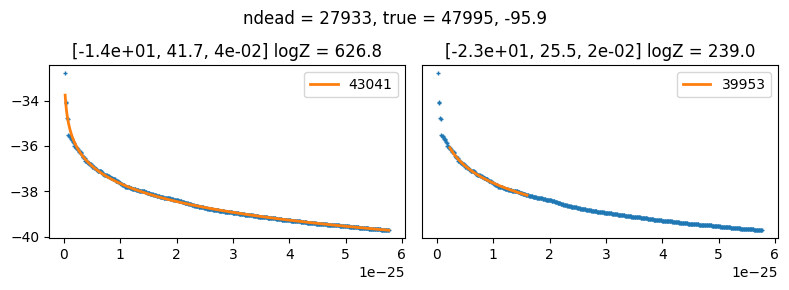

In [142]:
ndead = 27933
plot_split(model, ndead, splits=4, trunc=18)